In [1]:
from langgraph.graph import StateGraph ,START,END
from typing import TypedDict
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI

In [2]:
from pydantic import BaseModel, Field
from typing import Literal

In [3]:
load_dotenv()

True

In [4]:
model =ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [5]:
class tweetState(TypedDict):
    topic : str
    tweet : str
    evaluation : Literal['approved','reject']
    feedback : str
    iteration : int
    maxIteration : int

In [6]:
from langchain_core.messages import HumanMessage,SystemMessage

In [7]:
def generateTweet(state : tweetState):
     messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]
     response=model.invoke(messages).content
     return {
          'tweet': response
     }

In [9]:
class evalSchema(BaseModel):
    evaluation : Literal['approved','reject']
    feedback :str

In [10]:
evalModel=model.with_structured_output(evalSchema)

In [14]:
content1=f"""

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
"""

In [15]:
def evaluate(state : tweetState):
        messages = [SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),HumanMessage(content=f"""the following tweet: Tweet: "{state['tweet']}" """ + content1)
        ]
        response=evalModel.invoke(messages)
        return {
                'evaluation': response.evaluation,
                'feedback' : response.feedback
        }

In [19]:
def condition(state : tweetState):
    if(state['evaluation']=='approved' or state['maxIteration']==state['iteration']):
        return 'approved'
    else:
        return 'reject'

In [20]:
def optimize(state : tweetState):
    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
                     
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]
    response=model.invoke(messages)
    iteration= state['iteration']+1
    return {
        'tweet' : response.content,
        'iteration' : iteration
    }

In [22]:
graph=StateGraph(tweetState)
graph.add_node('generateTweet',generateTweet)
graph.add_node('evaluate',evaluate)
graph.add_node('optimize',optimize)


graph.add_edge(START, 'generateTweet')
graph.add_edge('generateTweet','evaluate')
graph.add_conditional_edges('evaluate',condition,
                            {
        "reject": "optimize", 
        "approved": END
    })
graph.add_edge('optimize','evaluate')
workflow=graph.compile()

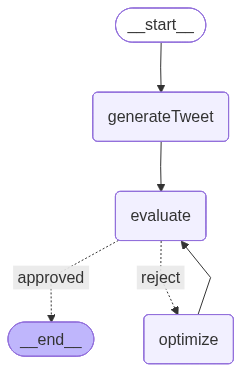

In [23]:
workflow

In [25]:
initial_state={
     "topic": "Person doing DSA intead of dev",
    "iteration": 1,
    "max_iteration": 5
}
workflow.invoke(initial_state)

{'topic': 'Person doing DSA intead of dev',
 'tweet': "My GitHub activity graph is flatlining, but my LeetCode streak is longer than my last relationship. Pretty sure I'm building *something*. Probably just anxiety. #DSA #DevLife",
 'evaluation': 'approved',
 'feedback': "This tweet effectively combines self-deprecating humor with relatable developer struggles. The comparison of a LeetCode streak to a relationship is a familiar trope, but the addition of 'Probably just anxiety' provides a fresh, genuinely funny, and punchy twist. It's concise, well-formatted, and highly shareable within the tech community, making it an excellent example of a viral-potential tweet. No generic throwaway lines dilute the humor.",
 'iteration': 1}